In [6]:
%%time
%reset -f

import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors   
from rdkit import Chem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect

curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = [
    '2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 
    'AD-18', 'AD-24', 'AD-25', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [
    3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 
    2.878, 2.686, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]
Homo_eV = [
    -5.1876, -5.4716, -5.5685, -5.5091, -5.6217, -5.6347, -5.1710, -6.6011, 
    -5.6247, -5.5399, -5.3205, -5.0740, -6.2168, -4.9084, -5.7404, -5.7209, 
    -5.3831, -5.8692, -5.4390]
Lumo_eV = [
    -2.1106, -2.3994, -2.3092, -2.8837, -2.6840, -2.6890, -2.3595, -3.3695, 
    -2.8896, -2.6622, -2.6347, -2.3040, -3.2160, -2.2062, -2.7706, -2.8307, 
    -2.5237, -2.7325, -2.9139]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame of Curcumin
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo (eV)': Homo_eV,
    'Lumo (eV)': Lumo_eV,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
curcumin_df_mf

CPU times: total: 156 ms
Wall time: 146 ms


,Molecule,Molecular Weight,LogP,Homo (eV),Lumo (eV),Homo-Lumo Gap (eV),Smiles,morgan_0,morgan_1,morgan_2,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,2-ADMeO3,532.345,5.02930,-5.1876,-2.1106,3.077,COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3-MR83a,472.293,5.01210,-5.4716,-2.3994,3.072,COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AD-10,472.293,5.01210,-5.5685,-2.3092,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AD-1013,482.335,7.29270,-5.5091,-2.8837,2.625,COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1cc...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AD-1022,472.293,5.01210,-5.6217,-2.6840,2.938,COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,AD-11,444.239,4.40610,-5.6347,-2.6890,2.946,COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+]...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,AD-14-Moore,438.327,5.10970,-5.1710,-2.3595,2.811,CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,AD-16-DMF,377.199,4.84938,-6.6011,-3.3695,3.231,N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,AD-18,506.357,7.88370,-5.6247,-2.8896,2.735,COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,AD-24,512.361,7.30130,-5.5399,-2.6622,2.878,COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'LUMO_calib_stds', 'HOMO_calib_stds',
    'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

opv_df_sorted = opv_df.sort_values(by='LUMO_calc')
opv_df_filtered = opv_df_sorted[opv_df_sorted['LUMO_calc'] <= -3.5]
opv_df_filtered.reset_index(drop=True, inplace=True)
opv_df_filtered

,smiles,HOMO_calc,LUMO_calc,LUMO_calib,HOMO_calib,GAP_calib,GAP_calc,mol
0,CN1C(=O)C2=C(C3=C(C#N)C(=C(C#N)C#N)SC3=O)N(C)C...,-6.884480,-5.415066,-5.785082,-6.877951,1.092869,1.469415,<rdkit.Chem.rdchem.Mol object at 0x00000249D9B...
1,N#CC(C#N)=C1SC(=O)C(c2cnc(C3=C(C#N)C(=C(C#N)C#...,-7.972936,-5.351299,-5.658418,-8.008956,2.350538,2.621637,<rdkit.Chem.rdchem.Mol object at 0x00000249D9B...
2,O=C(O)c1noc(-c2c3c(c(-c4onc(C(=O)O)c4C(=O)O)c4...,-7.091046,-5.349517,-5.779633,-7.231863,1.452230,1.741529,<rdkit.Chem.rdchem.Mol object at 0x00000249D93...
3,N#CC(C#N)=C1C=C(C(=O)O)OC(c2c3c(c(C4=CC(=C(C#N...,-6.754826,-5.224586,-5.484103,-6.830958,1.346855,1.530241,<rdkit.Chem.rdchem.Mol object at 0x00000249D93...
4,N#Cc1noc(-c2c3c(c(-c4onc(C#N)c4C(=O)O)c4cscc24...,-6.993326,-5.185199,-5.519700,-7.083920,1.564220,1.808127,<rdkit.Chem.rdchem.Mol object at 0x00000249D93...
...,...,...,...,...,...,...,...,...
12717,CN1C(=O)C(=Cc2nc3ccc(-c4cocc4C(=O)c4ccc(C(F)(F...,-6.654575,-3.500147,-3.991776,-6.753528,2.761752,3.154428,<rdkit.Chem.rdchem.Mol object at 0x00000249D9A...
12718,CN1C(=O)C(=Cc2ncc(-c3ccnc(-c4c5ccsc5nc5sc(F)c(...,-6.205515,-3.500108,-4.002464,-6.292875,2.290410,2.705406,<rdkit.Chem.rdchem.Mol object at 0x00000249FFC...
12719,CN1C(=O)C(=Cc2nccc(C=CC(=O)C=Cc3ccnc(C=C4SC(=S...,-6.304187,-3.500102,-3.838015,-6.314939,2.476924,2.804085,<rdkit.Chem.rdchem.Mol object at 0x00000249D93...
12720,CN1C(=O)C(=Cc2onc(-c3ncnc([SiH]4C=C5OCCOC5=C4)...,-6.185529,-3.500038,-4.152998,-6.280591,2.127593,2.685491,<rdkit.Chem.rdchem.Mol object at 0x00000249D93...


In [8]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect
import numpy as np

# Functions to generate fingerprints
def generate_morgan_fingerprint(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

def generate_maccs166_fingerprint(mol):
    return MACCSkeys.GenMACCSKeys(mol)

def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

def generate_fcfp_fingerprint(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=True)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Function to add fingerprint to dataframe
def add_fingerprint_to_df(df, fingerprint_func, fp_name):
    df[fp_name] = df['mol'].apply(fingerprint_func)
    return df

# Function to split fingerprints into separate bit columns
def split_fingerprint_bits(df, fp_column, prefix):
    bit_array = np.array([list(fp) for fp in df[fp_column].values])
    bit_columns = pd.DataFrame(bit_array, columns=[f'{prefix}_{i}' for i in range(bit_array.shape[1])])
    df = pd.concat([df.drop(columns=[fp_column]), bit_columns], axis=1)
    return df

# Assuming opv_df is already defined and 'mol' column has been created
# List of fingerprint generation functions and names
fingerprint_functions = [
    (generate_morgan_fingerprint, 'morgan_fp', 'morgan'),
    (generate_maccs166_fingerprint, 'maccs_fp', 'maccs'),
    (generate_atom_pair_fingerprint, 'atom_pair_fp', 'atom_pair'),
    (generate_fcfp_fingerprint, 'fcfp_fp', 'fcfp')
]

# List to store resulting dataframes
resulting_dfs = []

# Generate and store dataframes with fingerprints
for fp_func, fp_name, prefix in fingerprint_functions:
    df_copy = opv_df_filtered.copy()
    df_copy = add_fingerprint_to_df(df_copy, fp_func, fp_name)
    df_copy = split_fingerprint_bits(df_copy, fp_name, prefix)
    resulting_dfs.append(df_copy)
    print(f'Finished processing {prefix} fingerprints')

# The resulting_dfs list now contains your four dataframes with split fingerprint columns
opv_df_morgan = resulting_dfs[0]
opv_df_maccs = resulting_dfs[1]
opv_df_atom_pair = resulting_dfs[2]
opv_df_fcfp = resulting_dfs[3]

Finished processing morgan fingerprints
Finished processing maccs fingerprints
Finished processing atom_pair fingerprints
Finished processing fcfp fingerprints
CPU times: total: 59 s
Wall time: 59.5 s


In [16]:
%%time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
import numpy as np

# Define models
models = {
    'Bayesian Ridge': BayesianRidge(),
    'KNN Regressor': KNeighborsRegressor(),
    'LightGBM': LGBMRegressor(),
    'Ridge Regression': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'ElasticNet': ElasticNet(),
    'Extra Trees': ExtraTreesRegressor()
}

results = []

# Loop through each fingerprint dataset
for i, df in enumerate([opv_df_morgan, opv_df_maccs, opv_df_atom_pair, opv_df_fcfp]):
    fingerprint_type = ['Morgan', 'MACCS', 'Atom Pair', 'FCFP'][i]
    
    X = df.iloc[:, 8:]  
    y = df["LUMO_calc"] 
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Loop through each model
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # Print progress and store results
        print(f'Finished processing {fingerprint_type} fingerprints with {model_name} model:')
        
        results.append({
            'Fingerprint Type': fingerprint_type,
            'Regression Model': model_name,
            'R² Score': r2,
            'RMSE': rmse,
            'MAE': mae,
            'MSE': mse
        })
    print(f'Finished processing {fingerprint_type} fingerprints')

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

Finished processing Morgan fingerprints with Bayesian Ridge model:
Finished processing Morgan fingerprints with KNN Regressor model:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 9541, number of used features: 1145
[LightGBM] [Info] Start training from score -3.792905
Finished processing Morgan fingerprints with LightGBM model:
Finished processing Morgan fingerprints with Ridge Regression model:
Finished processing Morgan fingerprints with Decision Tree model:
Finished processing Morgan fingerprints with Random Forest model:
Finished processing Morgan fingerprints with Gradient Boosting model:
Finished processing Morgan fingerprints with SVR model:
Finished processing Morgan fingerprints with ElasticNet model:
Finished

,Fingerprint Type,Regression Model,R² Score,RMSE,MAE,MSE
0,Morgan,Bayesian Ridge,0.792692,0.109169,0.080328,0.011918
1,Morgan,KNN Regressor,0.621642,0.147483,0.113055,0.021751
2,Morgan,LightGBM,0.785115,0.111146,0.083294,0.012353
3,Morgan,Ridge Regression,0.792956,0.109099,0.079975,0.011903
4,Morgan,Decision Tree,0.505810,0.168553,0.115335,0.028410
5,Morgan,Random Forest,0.741119,0.121994,0.086863,0.014883
6,Morgan,Gradient Boosting,0.564655,0.158200,0.122232,0.025027
7,Morgan,SVR,0.831488,0.098425,0.074544,0.009687
8,Morgan,ElasticNet,-0.001209,0.239912,0.187603,0.057558
9,Morgan,Extra Trees,0.557567,0.159483,0.109738,0.025435


In [17]:
results_df.to_csv(r"C:\Users\Chamod Peiris\Documents\Initial Models Results.csv", index=False)

In [20]:
import plotly.graph_objects as go
import pandas as pd

# Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Create traces for R² Score
fig_r2 = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    subset = subset[subset['Regression Model'] != 'ElasticNet']
    fig_r2.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['R² Score'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['R² Score']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_r2.update_layout(
    title='R² Score by Regression Model and Fingerprint Type',
    xaxis_title='Regression Model',
    yaxis_title='R² Score',
    barmode='group',
    legend_title='Fingerprint Type'
)

# Create traces for RMSE
fig_rmse = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_rmse.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['RMSE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['RMSE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_rmse.update_layout(
    title='RMSE by Regression Model and Fingerprint Type',
    xaxis_title='Regression Model',
    yaxis_title='RMSE',
    barmode='group',
    legend_title='Fingerprint Type'
)

# Create traces for MAE
fig_mae = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_mae.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['MAE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['MAE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_mae.update_layout(
    title='MAE by Regression Model and Fingerprint Type',
    xaxis_title='Regression Model',
    yaxis_title='MAE',
    barmode='group',
    legend_title='Fingerprint Type'
)

# Show the plots
fig_r2.show()
fig_rmse.show()
fig_mae.show()

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
import numpy as np

# Define parameter grid for SVR only
param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5]
}

# Initialize an empty list to store the optimized results
optimized_results = []

# Iterate over the four dataframes
for i, df in enumerate([opv_df_morgan]):
    fingerprint_type = ['Morgan'][i]
    
    X = df.iloc[:, 8:]
    y = df["LUMO_calc"] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Perform grid search for SVR model
    model_name = 'SVR'
    print(f'Starting grid search for {model_name} model with {fingerprint_type} fingerprints...')
    
    grid_search = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model after grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions using the optimized model
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Append the results to the optimized_results list
    optimized_results.append({
        'Fingerprint Type': fingerprint_type,
        'Regression Model': model_name,
        'Best Parameters': grid_search.best_params_,
        'R² Score': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse
    })
    
    print(f'Finished processing {fingerprint_type} fingerprints with optimized {model_name} model')

# Convert the results to a DataFrame for analysis
optimized_results_df = pd.DataFrame(optimized_results)
optimized_results_df

Starting grid search for SVR model with Morgan fingerprints...
Finished processing Morgan fingerprints with optimized SVR model


,Fingerprint Type,Regression Model,Best Parameters,R² Score,RMSE,MAE,MSE
0,Morgan,SVR,"{'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}",0.886226,0.080874,0.05618,0.006541


**SVR Regression Model Grid Search**

- Best Parameters = {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}	

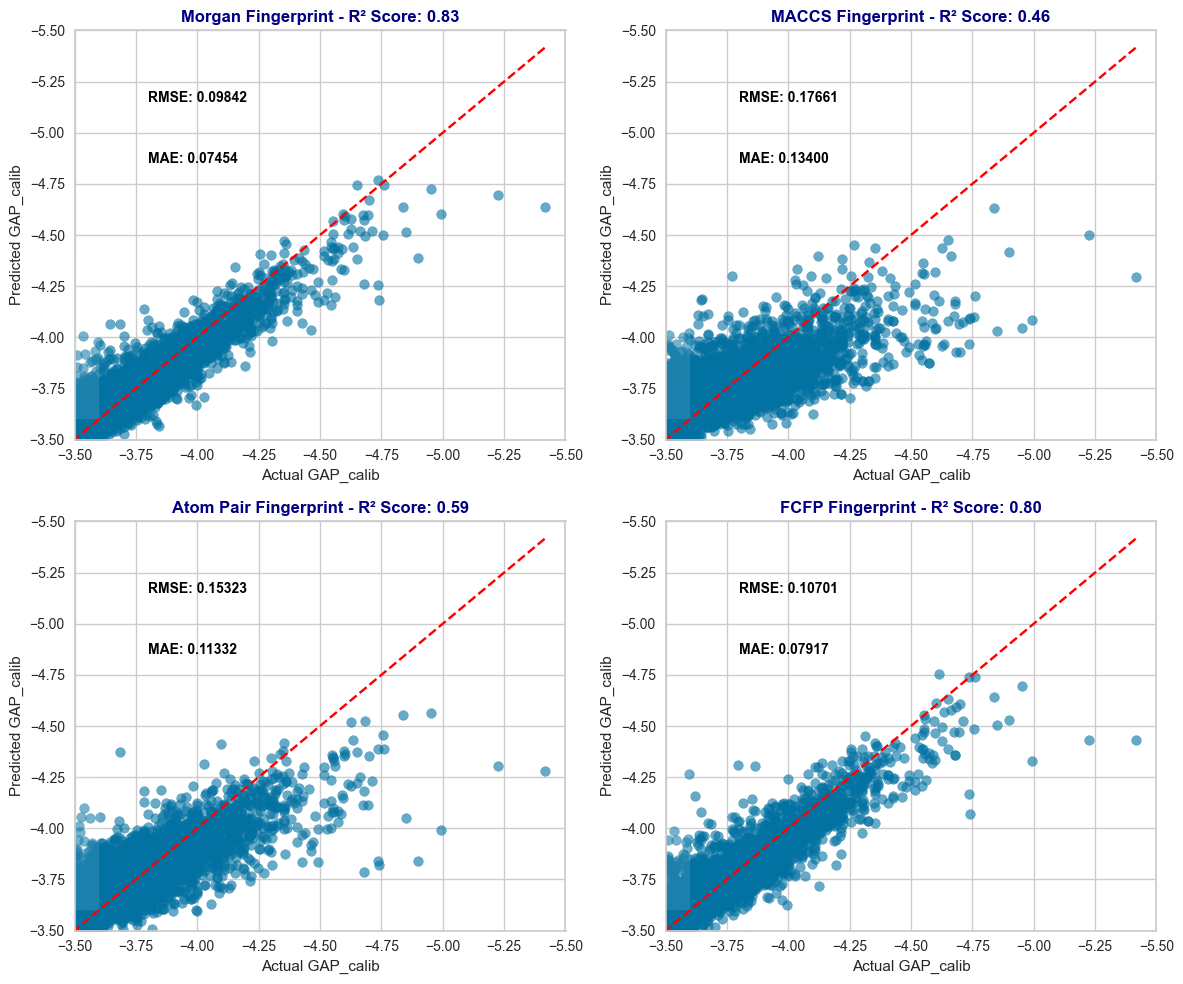

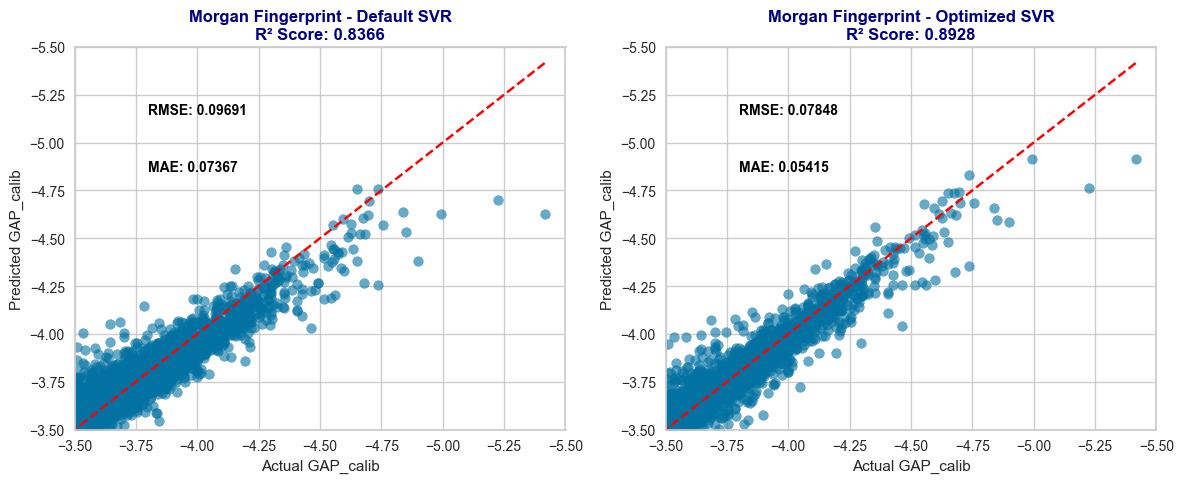

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# Define the dataframes and corresponding names
dataframes = {
    'Morgan': opv_df_morgan,
    'MACCS': opv_df_maccs,
    'Atom Pair': opv_df_atom_pair,
    'FCFP': opv_df_fcfp
}

# Set up the plot for each fingerprint type using default SVR
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration

# Iterate over the dataframes and plot actual vs predicted for default SVR
for idx, (fingerprint_name, df) in enumerate(dataframes.items()):
    X = df.iloc[:, 8:]  
    y = df["LUMO_calc"] 

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Define and train the default SVR model
    svr_model = SVR()
    svr_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svr_model.predict(X_test)

    # Calculate R² Score
    r2_score = svr_model.score(X_test, y_test)

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = np.mean(np.abs(y_test - y_pred))

    # Plot the actual vs predicted
    axes[idx].scatter(y_test, y_pred, alpha=0.6)
    axes[idx].plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # 45-degree line
    axes[idx].set_title(f'{fingerprint_name} Fingerprint - R² Score: {r2_score:.2f}', fontsize=12, weight='bold', color='navy')
    axes[idx].set_xlabel('Actual GAP_calib')
    axes[idx].set_ylabel('Predicted GAP_calib')

    # X and Y limits
    axes[idx].set_xlim(-3.5, -5.5)
    axes[idx].set_ylim(-3.5, -5.5)

    # Add RMSE and MAE to the plot
    axes[idx].text(-3.8, -5.15, f'RMSE: {rmse:.5f}', fontsize=10, color='black', weight='bold')
    axes[idx].text(-3.8, -4.85, f'MAE: {mae:.5f}', fontsize=10, color='black', weight='bold')

    # Draw a rectangle for the text background
    axes[idx].add_patch(plt.Rectangle((-3.6, -4.4), 1.6, 0.8, fill=True, color='white', alpha=0.1))

# Adjust layout for the main plot
plt.tight_layout()
plt.show()

# Now, compare the default and optimized SVR models for Morgan fingerprint side-by-side
# Set up the plot for Morgan fingerprint
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Default SVR Model
X_morgan = opv_df_morgan.iloc[:, 8:]  # Features for Morgan fingerprint
y_morgan = opv_df_morgan["LUMO_calc"]  # Target for LUMO_calc

X_train, X_test, y_train, y_test = train_test_split(X_morgan, y_morgan, test_size=0.2, random_state=42)

# Default SVR model
default_svr = SVR()
default_svr.fit(X_train, y_train)
y_pred_default = default_svr.predict(X_test)
r2_default = default_svr.score(X_test, y_test)
rmse_default = np.sqrt(mean_squared_error(y_test, y_pred_default))
mae_default = np.mean(np.abs(y_test - y_pred_default))

# Plot default model results
ax1.scatter(y_test, y_pred_default, alpha=0.6)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
ax1.set_title(f'Morgan Fingerprint - Default SVR\nR² Score: {r2_default:.4f}', fontsize=12, weight='bold', color='navy')
ax1.set_xlabel('Actual GAP_calib')
ax1.set_ylabel('Predicted GAP_calib')
ax1.set_xlim(-3.5, -5.5)
ax1.set_ylim(-3.5, -5.5)
ax1.text(-3.8, -5.15, f'RMSE: {rmse_default:.5f}', fontsize=10, color='black', weight='bold')
ax1.text(-3.8, -4.85, f'MAE: {mae_default:.5f}', fontsize=10, color='black', weight='bold')

# Optimized SVR Model
optimized_svr = SVR(C=10, epsilon=0.01, kernel='rbf')
optimized_svr.fit(X_train, y_train)
y_pred_optimized = optimized_svr.predict(X_test)
r2_optimized = optimized_svr.score(X_test, y_test)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
mae_optimized = np.mean(np.abs(y_test - y_pred_optimized))

# Plot optimized model results
ax2.scatter(y_test, y_pred_optimized, alpha=0.6)
ax2.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
ax2.set_title(f'Morgan Fingerprint - Optimized SVR\nR² Score: {r2_optimized:.4f}', fontsize=12, weight='bold', color='navy')
ax2.set_xlabel('Actual GAP_calib')
ax2.set_ylabel('Predicted GAP_calib')
ax2.set_xlim(-3.5, -5.5)
ax2.set_ylim(-3.5, -5.5)
ax2.text(-3.8, -5.15, f'RMSE: {rmse_optimized:.5f}', fontsize=10, color='black', weight='bold')
ax2.text(-3.8, -4.85, f'MAE: {mae_optimized:.5f}', fontsize=10, color='black', weight='bold')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()